In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [2]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import pandas as pd
import os
import random

from tqdm import tqdm
from src.data.loaders import get_loader
from joblib import Parallel, delayed
from functools import partial
%load_ext autoreload
%autoreload 2

2024-08-27 17:01:49.921355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 17:01:49.921402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 17:01:49.921431: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 17:01:49.929247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## MACHO stats

In [3]:
def get_stat(path, on='mag', window=100):
    observations = pd.read_parquet(path)
    observations = observations[(observations['errmag']>0) & (observations['errmag']<1)]
    
    if on == 'mjd':
        observations = observations.groupby('newID').diff().mean().reset_index()
        observations = observations[observations['index']==on].iloc[:, -1].values[0]
        return observations
        
    observations = observations.sort_values(on)
    observations = observations[on].rolling(window=window, step=window).mean()
    return observations.dropna().tolist()

def calculate_stat(root, on='mag', window=1000, njobs=4):
    lc_paths = os.listdir(root)
    preloaded = partial(get_stat, on=on, window=window)
    var = Parallel(n_jobs=njobs, backend='threading')
    results = var(delayed(preloaded)(os.path.join(root, p)) for p in lc_paths )
    flattened = [item for sublist in results for item in sublist]
    return flattened

In [4]:
%%time
root = './data/raw_parquet/macho/light_curves/'
macho_mag = calculate_stat(root, on='mjd', njobs=32)

TypeError: 'numpy.float64' object is not iterable

In [5]:
%%time
root = './data/raw_parquet/alcock/light_curves/'
alcock_mag = calculate_stat(root, on='mjd', njobs=32)

TypeError: 'numpy.float64' object is not iterable

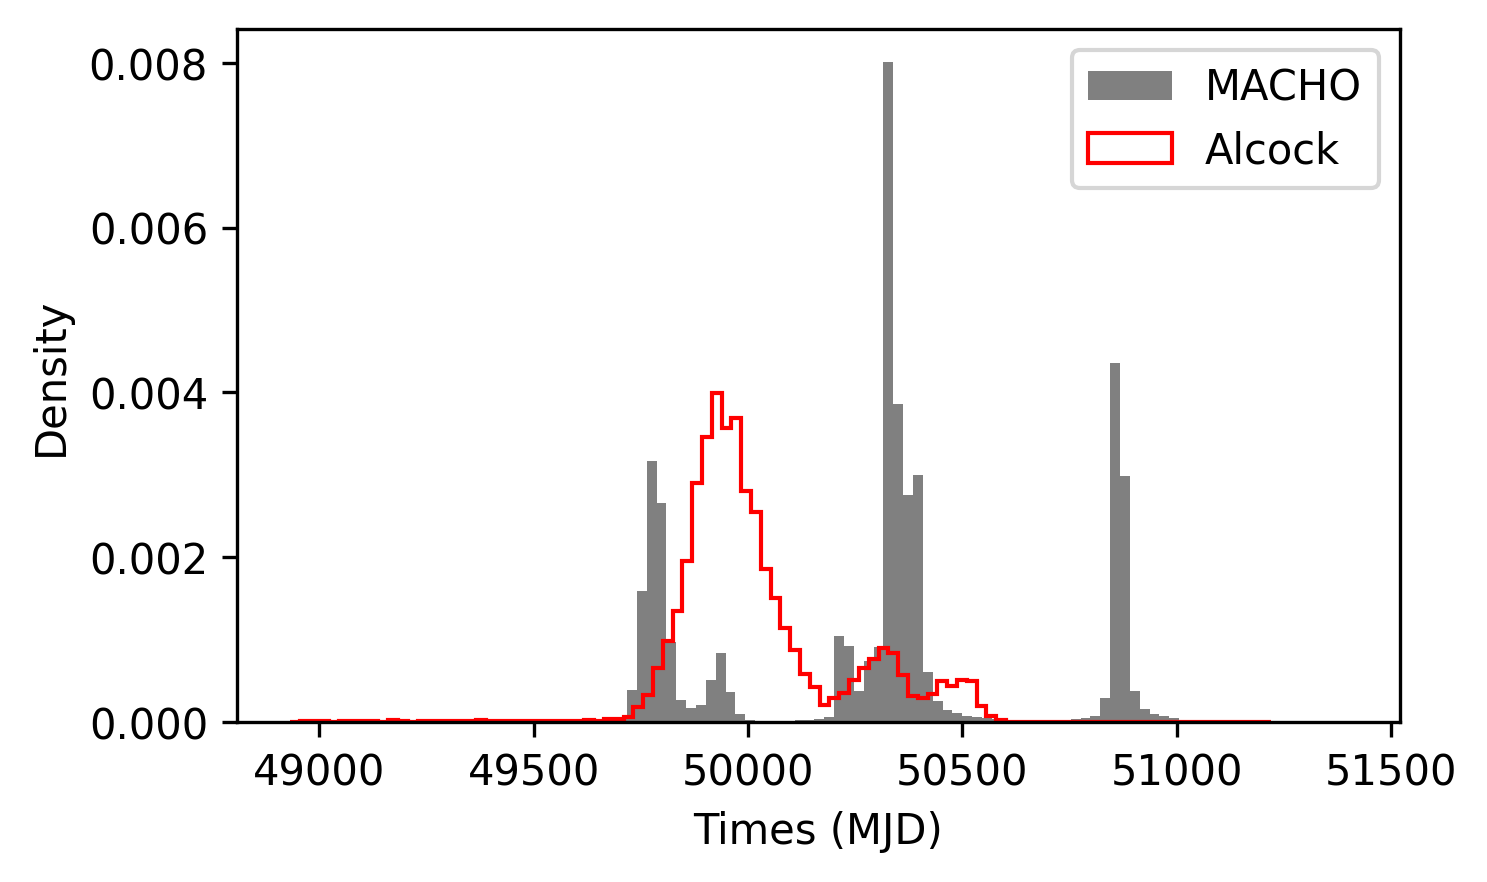

CPU times: user 3.38 s, sys: 491 ms, total: 3.87 s
Wall time: 3.52 s


In [52]:
%%time
plt.figure(figsize=(5, 3), dpi=300)
h1 = plt.hist(macho_mag, bins=100,  density=True, label='MACHO', histtype='stepfilled', color='gray')
h2 = plt.hist(alcock_mag, bins=100,  density=True, label='Alcock', histtype='step', color='r')
plt.legend()
plt.xlabel('Times (MJD)')
plt.ylabel('Density')
plt.savefig('./presentation/figures/macho_vs_alcock_mag.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
scan2 = pl.scan_parquet('./data/raw_parquet/alcock/light_curves/*.parquet')

In [57]:
%%time

# pscan2    = scan2.group_by('newID').agg([mean, std, median, min_, max_])
# features2 = pscan2.collect()

CPU times: user 708 μs, sys: 95 μs, total: 803 μs
Wall time: 665 μs


/tmp/ipykernel_3885663/3473373314.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(xticks, means, stds, fmt='.k', lw=4, color='black')


<ErrorbarContainer object of 3 artists>

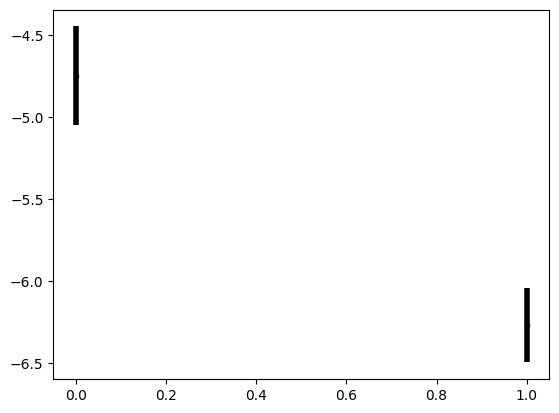

In [51]:
labels = ['MACHO', 'Alcock']
xticks = np.arange(len(labels))

means = np.array([features['mean'].mean(), features2['mean'].mean()])
stds = np.array([features['std'].mean(), features2['std'].mean()])
mins = np.array([features['min'].min(), features2['min'].min()])
maxes = np.array([features['max'].max(), features2['max'].max()])


# plt.errorbar(xticks, means, [means - mins, maxes - means], fmt='.k', ecolor='gray', lw=0.5)
plt.errorbar(xticks, means, stds, fmt='.k', lw=4, color='black')
